# Objective



# PROBLEM SETTING
Commercial corn is processed into multiple food and industrial products. It is widely known as one of the world’s most important crops. Each year, plant breeders create new corn products, known as experimental hybrids, by crossing two “parents” together. The parents are known as inbreds and the development of the inbreds takes up the bulk of a corn breeding program. Most of that effort is spent evaluating the inbreds by crossing to another inbred, called a “tester.” 

It is a plant breeder’s job to identify the best parent combinations by creating experimental hybrids and assessing the hybrids’ performance by “testing” it in multiple environments to identify the hybrids that perform best. Historically, identifying the best hybrids has been by trial and error, with breeders testing their experimental hybrids in a diverse set of locations and measuring their performance, then selecting the highest yielding hybrids. The process of selecting the correct parent combinations and testing the experimental hybrids can take many years and is inefficient, simply due to the number of potential parent combinations to create and test.

RESEARCH QUESTION
Given historical hybrid (inbred by tester) performance data across years and locations, how can we create a model to predict/impute the performance of the crossing of any two inbred and tester parents? 

For example, given 5,000 inbreds (parents), the number of potential crosses is 12,497,500 —far more than can be created or tested. Due to limited testing resources, breeders are only able to select a small subset of all the possible inbred combinations, which can lead to lost opportunities. 

This issue is the basis for the 2020 Syngenta Crop Challenge in Analytics. Can an accurate model be constructed to predict the performance of crossing any two inbreds? Such a model would allow breeders to focus on the best possible combinations. 

In simpler terms, can we use hybrid data collected from crossing inbreds and testers together to predict the result of cross combinations that have not yet been created and tested? Namely, are we able to construct a recommender system to propose new parent combinations based on the hybrid performance from other parent combinations and attributes they have in common? 

The following Table 1 is an illustration of the challenge. Each “X” is the set of observed performance data points of hybrids from their corresponding inbred by tester combinations. With the information from the table, how can a model be built to predict/impute the mean yield of each missing combinations (“?”)?


RESEARCH QUESTION
Given historical hybrid (inbred by tester) performance data across years and locations, how can we create a model to predict/impute the performance of the crossing of any two inbred and tester parents? 

OBJECTIVE
The objective is to estimate yield performance of the cross between inbred and tester combinations in a given holdout set. Specifically, we are asking for the mean yield performance of each inbred by tester combination in the holdout set. 

Notes
Each response in the holdout must be completed
Many approaches can be used such as statistical approaches, machine learning and collaborative filtering

Deliverables
Predicted yield values of the cross between inbred and tester combinations in the test set.
Additionally, observing the standards for academic publication, entries should include a written report with the following:
Quantitative results to justify your modeling and classification techniques
A clear description of the methodology and theory used
References or citations as appropriate

Evaluation
The entries will be evaluated based on:
Accuracy of the predicted values in the test set based on root mean squared error
Simplicity and intuitiveness of the solution
Clarity in the explanation
The quality and clarity of the finalist’s presentation at the 2020 INFORMS Conference on Business Analytics and Operations Research

dataset
Training Dataset: This dataset contains the observed yield (consistently scaled to an internal benchmark) for a large set of corn hybrids tested across multiple environments between 2016 and 2018. These hybrids are created through the crossing of 593 unique inbreds and 496 unique testers. Creating a two-way table of means with inbreds as rows and testers as columns results in a data table with approximately 96% missing values. Each row contains the year and location ID of the observation. Additionally, each row includes a cluster value for each inbred and tester. This represents the genetic grouping of the inbreds and testers and has been determined using internal methods. Inbreds and testers are not treated any differently when clustering, so a shared cluster value indicates genetic similarity regardless of whether a parent is defined as an inbred or a tester. Contestants may (or may not) find these columns useful.

Test Dataset: This dataset contains a set of inbred and tester combinations that need to be predicted as part of the challenge. The mean yield is to be predicted for each listed combination of inbred by tester.


Training Dataset	YEAR	Year grown
LOCATION	ID for each location
INBRED	ID for Inbred
INBRED_CLUSTER	Cluster association for each inbred which denotes genetic grouping
TESTER	ID for Tester
TESTER_CLUSTER	Cluster association for each tester which denotes genetic grouping
YIELD	The performance of the Line and Tester combination


Testing Dataset	INBRED	ID for INBRED
INBRED_CLUSTER	Cluster association for each line which denotes genetic grouping
TESTER	ID for Tester
TESTER_CLUSTER	Cluster association for each tester which denotes genetic grouping
YIELD	The performance of the Line and Tester combination – to be predicted

timeline December 1
Main metric root mean square error



# Load libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, f1_score, confusion_matrix, recall_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder  
from sklearn.preprocessing import StandardScaler  
from scipy import sparse
from catboost import CatBoostRegressor
import lightgbm as lgb

/Users/edima/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Load Data

In [4]:
train = pd.read_csv('CC2020_train_final.csv')
test = pd.read_csv('CC2020_test_final.csv')

In [3]:
train.shape

(199476, 7)

In [4]:
train.head()

,YEAR,LOCATION,INBRED,INBRED_CLUSTER,TESTER,TESTER_CLUSTER,YIELD
0,18,Loc 5608,Inbred_142,Cluster11,Tester_740,Cluster10,1.135462
1,18,Loc 4533,Inbred_142,Cluster11,Tester_740,Cluster10,1.139813
2,18,Loc 5620,Inbred_142,Cluster11,Tester_740,Cluster10,1.117778
3,18,Loc 4732,Inbred_142,Cluster11,Tester_740,Cluster10,1.171366
4,18,Loc 5500,Inbred_142,Cluster11,Tester_740,Cluster10,1.059364


In [5]:
train.describe()

,YEAR,YIELD
count,199476.000000,199476.000000
mean,17.160551,1.001731
std,0.741779,0.104722
min,16.000000,0.047236
25%,17.000000,0.941870
50%,17.000000,1.003277
75%,18.000000,1.064073
max,18.000000,1.800083


In [6]:
test.head()

,INBRED,INBRED_CLUSTER,TESTER,TESTER_CLUSTER,YIELD
0,Inbred_1071,Cluster8,Tester_5450,Cluster5,NaN
1,Inbred_122,Cluster12,Tester_4336,Cluster6,NaN
2,Inbred_1337,Cluster17,Tester_2652,Cluster1,NaN
3,Inbred_1337,Cluster17,Tester_4373,Cluster3,NaN
4,Inbred_1339,Cluster17,Tester_4238,Cluster11,NaN


In [7]:
test.describe()

,YIELD
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [8]:
train.dtypes

YEAR                int64
LOCATION           object
INBRED             object
INBRED_CLUSTER     object
TESTER             object
TESTER_CLUSTER     object
YIELD             float64
dtype: object

# EDA

In [9]:
#check year column
train.YEAR.unique()

array([18, 17, 16])

In [10]:
#check location
train.LOCATION.unique()

array(['Loc 5608', 'Loc 4533', 'Loc 5620', 'Loc 4732', 'Loc 5500',
       'Loc 5514', 'Loc 4742', 'Loc 4625', 'Loc 4620', 'Loc 4524',
       'Loc 4442', 'Loc 4400', 'Loc 5420', 'Loc 4621', 'Loc 4601',
       'Loc 4532', 'Loc 4424', 'Loc 4341', 'Loc 4515', 'Loc 6609',
       'Loc 5424', 'Loc 5320', 'Loc 6415', 'Loc 4439', 'Loc 6730',
       'Loc 5330', 'Loc 5610', 'Loc 6700', 'Loc 6532', 'Loc 5711',
       'Loc 6634', 'Loc 6511', 'Loc 4623', 'Loc 4523', 'Loc 4Z23',
       'Loc 3631', 'Loc 3601', 'Loc 6418', 'Loc 6601', 'Loc 6614',
       'Loc 5511', 'Loc 4326', 'Loc 5324', 'Loc 4420', 'Loc 3437',
       'Loc 4401', 'Loc 3439', 'Loc 5336', 'Loc 7345', 'Loc 5340',
       'Loc 7319', 'Loc 6310', 'Loc 6421', 'Loc 7420', 'Loc 5240',
       'Loc 6320', 'Loc 8405', 'Loc 8316', 'Loc 7311', 'Loc 7612',
       'Loc 7332', 'Loc 7303', 'Loc 6734', 'Loc 7632', 'Loc 8320',
       'Loc 7243', 'Loc 8234', 'Loc 7440', 'Loc 7520', 'Loc 6334',
       'Loc 7727', 'Loc 7528', 'Loc 6719', 'Loc 7D06', 'Loc 73

In [11]:
#check INBRED
train.INBRED.unique()

array(['Inbred_142', 'Inbred_740', 'Inbred_743', 'Inbred_19',
       'Inbred_755', 'Inbred_737', 'Inbred_733', 'Inbred_739',
       'Inbred_754', 'Inbred_748', 'Inbred_750', 'Inbred_727',
       'Inbred_753', 'Inbred_586', 'Inbred_752', 'Inbred_736',
       'Inbred_749', 'Inbred_725', 'Inbred_761', 'Inbred_756',
       'Inbred_760', 'Inbred_757', 'Inbred_768', 'Inbred_765',
       'Inbred_764', 'Inbred_769', 'Inbred_759', 'Inbred_741',
       'Inbred_747', 'Inbred_745', 'Inbred_731', 'Inbred_773',
       'Inbred_738', 'Inbred_145', 'Inbred_777', 'Inbred_804',
       'Inbred_724', 'Inbred_122', 'Inbred_799', 'Inbred_803',
       'Inbred_732', 'Inbred_801', 'Inbred_800', 'Inbred_770',
       'Inbred_805', 'Inbred_751', 'Inbred_771', 'Inbred_744',
       'Inbred_790', 'Inbred_746', 'Inbred_1339', 'Inbred_789',
       'Inbred_1071', 'Inbred_1342', 'Inbred_1345', 'Inbred_1341',
       'Inbred_1346', 'Inbred_1340', 'Inbred_1349', 'Inbred_1360',
       'Inbred_1358', 'Inbred_1354', 'Inbred_13

In [12]:
#Inbred cluster
train.INBRED_CLUSTER.unique()

array(['Cluster11', 'Cluster10', 'Cluster12', 'Cluster8', 'Cluster17',
       'Cluster5', 'Cluster1', 'Cluster4', 'Cluster7', 'Cluster3',
       'Cluster14', 'Cluster6', 'Cluster9', 'Cluster2'], dtype=object)

In [13]:
#Tester information
train.TESTER.unique()

array(['Tester_740', 'Tester_743', 'Tester_757', 'Tester_761',
       'Tester_767', 'Tester_775', 'Tester_776', 'Tester_779',
       'Tester_789', 'Tester_793', 'Tester_813', 'Tester_819',
       'Tester_821', 'Tester_828', 'Tester_829', 'Tester_1345',
       'Tester_1349', 'Tester_1397', 'Tester_2636', 'Tester_2652',
       'Tester_2683', 'Tester_2689', 'Tester_2690', 'Tester_2721',
       'Tester_2724', 'Tester_2736', 'Tester_2747', 'Tester_2773',
       'Tester_3404', 'Tester_3440', 'Tester_3484', 'Tester_3485',
       'Tester_3504', 'Tester_3507', 'Tester_3521', 'Tester_3565',
       'Tester_3567', 'Tester_3573', 'Tester_3577', 'Tester_3582',
       'Tester_3791', 'Tester_3796', 'Tester_4025', 'Tester_4048',
       'Tester_4051', 'Tester_4059', 'Tester_4062', 'Tester_4063',
       'Tester_4065', 'Tester_4067', 'Tester_4072', 'Tester_4082',
       'Tester_4083', 'Tester_4097', 'Tester_4099', 'Tester_4102',
       'Tester_4115', 'Tester_4119', 'Tester_4131', 'Tester_4135',
       'Te

In [14]:
#TESTER_CLUSTER
train.TESTER_CLUSTER.unique()

array(['Cluster10', 'Cluster5', 'Cluster4', 'Cluster8', 'Cluster17',
       'Cluster11', 'Cluster1', 'Cluster3', 'Cluster7', 'Cluster12',
       'Cluster6', 'Cluster14', 'Cluster2'], dtype=object)

In [15]:
#Yield information
train.YIELD.unique()

array([1.13546205, 1.13981255, 1.1177782 , ..., 0.97258388, 0.90014022,
       0.95307504])

In [16]:
test.dtypes

INBRED             object
INBRED_CLUSTER     object
TESTER             object
TESTER_CLUSTER     object
YIELD             float64
dtype: object

In [4]:
print(test.dtypes)
print(train.dtypes)

INBRED             object
INBRED_CLUSTER     object
TESTER             object
TESTER_CLUSTER     object
YIELD             float64
dtype: object
YEAR                int64
LOCATION           object
INBRED             object
INBRED_CLUSTER     object
TESTER             object
TESTER_CLUSTER     object
YIELD             float64
dtype: object


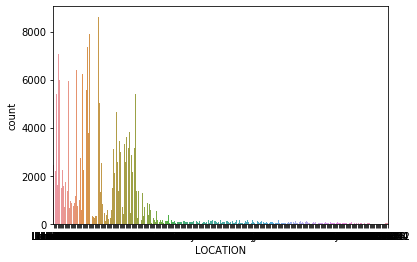

In [5]:
#FREQUENCY DISTIBUTION OF LOCATION
sns.countplot(data = train, x = 'LOCATION')

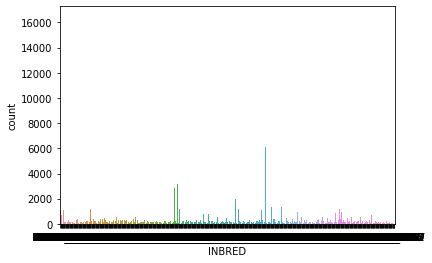

In [6]:
#frequency distribtion of inbred
sns.countplot(data = train, x = 'INBRED')


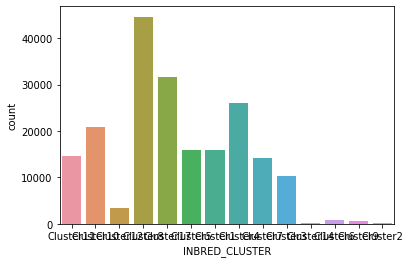

In [7]:
#frequency distribtion of inbred CLUSTER
sns.countplot(data = train, x = 'INBRED_CLUSTER')

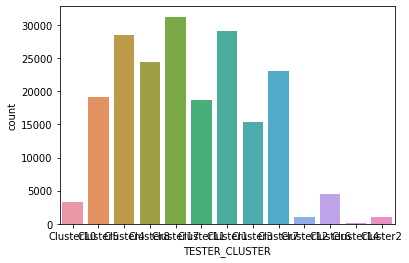

In [8]:
#frequency distribtion of TESTER CLUSTER
sns.countplot(data = train, x = 'TESTER_CLUSTER')

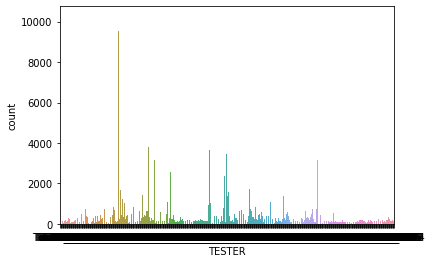

In [9]:
#frequency distribtion of TESTER
sns.countplot(data = train, x = 'TESTER')

# Data modelling

In [18]:
#Create new training and test dataset
df_train = train[train['YEAR']<18]
df_test = train[train['YEAR']==18]

In [19]:
df_train.shape

(126013, 7)

In [20]:
df_test.shape

(73463, 7)

In [21]:
#drop the YEAR column in new train and test data
df_train = df_train.drop(['YEAR'], axis=1)
df_test = df_test.drop(['YEAR'], axis=1)

# Catboost models

In [18]:
from catboost import CatBoostRegressor

In [22]:
#check for missing data
df_train.isnull().sum()

LOCATION          0
INBRED            0
INBRED_CLUSTER    0
TESTER            0
TESTER_CLUSTER    0
YIELD             0
dtype: int64

In [24]:
df_test.isnull().sum()

LOCATION          0
INBRED            0
INBRED_CLUSTER    0
TESTER            0
TESTER_CLUSTER    0
YIELD             0
dtype: int64

# Catboost model 1

In [32]:
#split training data set
X_train = df_train.drop(['YIELD'], axis=1)
y_train = df_train.YIELD

def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]

categorical = ["LOCATION",'INBRED','INBRED_CLUSTER','TESTER','TESTER_CLUSTER']
categorical_features_indices = column_index(X_train, categorical)

#split test dataset
X_test = df_test.drop(['YIELD'], axis=1)
y_test = df_test.YIELD

model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')


In [33]:
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9079580	test: 0.9068307	best: 0.9068307 (0)	total: 220ms	remaining: 10.8s
1:	learn: 0.8183662	test: 0.8173546	best: 0.8173546 (1)	total: 296ms	remaining: 7.1s
2:	learn: 0.7378618	test: 0.7369740	best: 0.7369740 (2)	total: 332ms	remaining: 5.2s
3:	learn: 0.6655519	test: 0.6648036	best: 0.6648036 (3)	total: 365ms	remaining: 4.19s
4:	learn: 0.6006293	test: 0.6000359	best: 0.6000359 (4)	total: 404ms	remaining: 3.63s
5:	learn: 0.5423746	test: 0.5419530	best: 0.5419530 (5)	total: 445ms	remaining: 3.27s
6:	learn: 0.4901394	test: 0.4899111	best: 0.4899111 (6)	total: 473ms	remaining: 2.9s
7:	learn: 0.4433351	test: 0.4433507	best: 0.4433507 (7)	total: 500ms	remaining: 2.63s
8:	learn: 0.4014442	test: 0.4016884	best: 0.4016884 (8)	total: 533ms	remaining: 2.43s
9:	learn: 0.3639901	test: 0.3645132	best: 0.3645132 (9)	total: 562ms	remaining: 2.25s
10:	learn: 0.3305605	test: 0.3313620	best: 0.3313620 (10)	total: 592ms	remaining: 2.1s
11:	learn: 0.3007684	test: 0.3018669	best: 0.3018669 (11

In [34]:
#Catboost parameter tuning
model =  CatBoostRegressor(iterations=700,
                             learning_rate=0.01,
                             depth=16,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
model.fit(X_train, y_train,
                 eval_set=(X_test, y_test),
                 cat_features=categorical_features_indices,
                 use_best_model=True)

0:	learn: 0.9976713	test: 0.9964609	best: 0.9964609 (0)	total: 95.1ms	remaining: 1m 6s
75:	learn: 0.4780105	test: 0.4777966	best: 0.4777966 (75)	total: 5.42s	remaining: 44.5s
150:	learn: 0.2420439	test: 0.2439950	best: 0.2439950 (150)	total: 11.1s	remaining: 40.2s
225:	learn: 0.1446771	test: 0.1496752	best: 0.1496752 (225)	total: 16.8s	remaining: 35.2s
300:	learn: 0.1113195	test: 0.1187648	best: 0.1187648 (300)	total: 35.4s	remaining: 46.9s
375:	learn: 0.1009972	test: 0.1109434	best: 0.1109434 (375)	total: 1m 50s	remaining: 1m 35s
450:	learn: 0.0963683	test: 0.1098246	best: 0.1098246 (450)	total: 3m 58s	remaining: 2m 11s
525:	learn: 0.0932419	test: 0.1100350	best: 0.1098137 (459)	total: 6m 8s	remaining: 2m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1098136912
bestIteration = 459

Shrink model to first 460 iterations.


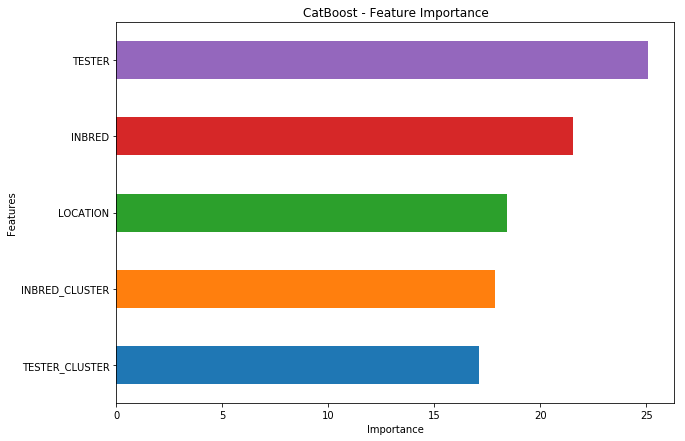

In [36]:
#Catboost feature importance
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X_train.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

# Catboost model 2

In [ ]:
train = pd.read_csv('CC2020_train_final.csv')
test = pd.read_csv('CC2020_test_final.csv')

In [ ]:
#Create new training and test dataset
df_train = train[train['YEAR']<18]
df_test = train[train['YEAR']==18]

In [ ]:
#drop the YEAR column in new train and test data
df_train = df_train.drop(['YEAR'], axis=1)
df_test = df_test.drop(['YEAR'], axis=1)

In [37]:
#create new model without location
#drop the YEAR column in new train and test data
df_train = df_train.drop(['LOCATION'], axis=1)
df_test = df_test.drop(['LOCATION'], axis=1)

In [38]:
#split training data set
X_train = df_train.drop(['YIELD'], axis=1)
y_train = df_train.YIELD

def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]

categorical = ['INBRED','INBRED_CLUSTER','TESTER','TESTER_CLUSTER']
categorical_features_indices = column_index(X_train, categorical)

#split test dataset
X_test = df_test.drop(['YIELD'], axis=1)
y_test = df_test.YIELD

model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9079622	test: 0.9068287	best: 0.9068287 (0)	total: 73.4ms	remaining: 3.6s
1:	learn: 0.8183681	test: 0.8173904	best: 0.8173904 (1)	total: 145ms	remaining: 3.49s
2:	learn: 0.7378577	test: 0.7370081	best: 0.7370081 (2)	total: 170ms	remaining: 2.66s
3:	learn: 0.6655491	test: 0.6648425	best: 0.6648425 (3)	total: 238ms	remaining: 2.73s
4:	learn: 0.6006218	test: 0.6002226	best: 0.6002226 (4)	total: 290ms	remaining: 2.61s
5:	learn: 0.5423668	test: 0.5421390	best: 0.5421390 (5)	total: 350ms	remaining: 2.56s
6:	learn: 0.4901261	test: 0.4900904	best: 0.4900904 (6)	total: 366ms	remaining: 2.25s
7:	learn: 0.4433210	test: 0.4434967	best: 0.4434967 (7)	total: 380ms	remaining: 1.99s
8:	learn: 0.4014301	test: 0.4018367	best: 0.4018367 (8)	total: 410ms	remaining: 1.87s
9:	learn: 0.3639705	test: 0.3645650	best: 0.3645650 (9)	total: 435ms	remaining: 1.74s
10:	learn: 0.3305307	test: 0.3314487	best: 0.3314487 (10)	total: 455ms	remaining: 1.61s
11:	learn: 0.3007322	test: 0.3019922	best: 0.3019922

In [39]:
#Catboost parameter tuning
model =  CatBoostRegressor(iterations=700,
                             learning_rate=0.01,
                             depth=16,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
model.fit(X_train, y_train,
                 eval_set=(X_test, y_test),
                 cat_features=categorical_features_indices,
                 use_best_model=True)

0:	learn: 0.9976701	test: 0.9964447	best: 0.9964447 (0)	total: 76.9ms	remaining: 53.8s
75:	learn: 0.4779924	test: 0.4778296	best: 0.4778296 (75)	total: 4.28s	remaining: 35.2s
150:	learn: 0.2420424	test: 0.2440032	best: 0.2440032 (150)	total: 9.07s	remaining: 33s
225:	learn: 0.1446584	test: 0.1497285	best: 0.1497285 (225)	total: 12.9s	remaining: 27.1s
300:	learn: 0.1121197	test: 0.1196393	best: 0.1196393 (300)	total: 19.9s	remaining: 26.4s
375:	learn: 0.1023911	test: 0.1114900	best: 0.1114900 (375)	total: 49.3s	remaining: 42.5s
450:	learn: 0.0989105	test: 0.1098295	best: 0.1098295 (450)	total: 1m 54s	remaining: 1m 3s
525:	learn: 0.0969149	test: 0.1100033	best: 0.1097981 (474)	total: 3m 12s	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1097981028
bestIteration = 474

Shrink model to first 475 iterations.


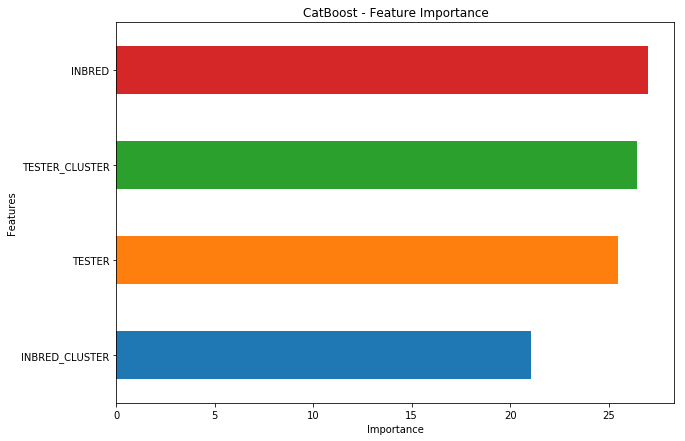

In [40]:
#Catboost feature importance
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X_train.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [41]:
#run model on validation data
test.shape

(1200, 5)

In [42]:
df_train.shape

(126013, 5)

In [43]:
#drop the YIELD column in the validation set
test = test.drop(['YIELD'], axis=1)

In [45]:
test.shape

(1200, 4)

In [47]:
submission = pd.DataFrame()
submission['YIELD'] = model.predict(test)

In [48]:
submission.head()

,YIELD
0,1.018099
1,0.974615
2,0.990679
3,0.973691
4,0.976075


In [50]:
#combine test and yield
test_yield_all = pd.concat([test, submission], axis = 1)

In [51]:
test_yield_all.head()

,INBRED,INBRED_CLUSTER,TESTER,TESTER_CLUSTER,YIELD
0,Inbred_1071,Cluster8,Tester_5450,Cluster5,1.018099
1,Inbred_122,Cluster12,Tester_4336,Cluster6,0.974615
2,Inbred_1337,Cluster17,Tester_2652,Cluster1,0.990679
3,Inbred_1337,Cluster17,Tester_4373,Cluster3,0.973691
4,Inbred_1339,Cluster17,Tester_4238,Cluster11,0.976075


# Catboost model 3

In [2]:
train = pd.read_csv('CC2020_train_final.csv')
test = pd.read_csv('CC2020_test_final.csv')

In [3]:
#Create new training and test dataset
df_train = train[train['YEAR']<18]
df_test = train[train['YEAR']==18]

In [49]:
df_train.columns

Index(['YEAR', 'LOCATION', 'INBRED', 'INBRED_CLUSTER', 'TESTER',
       'TESTER_CLUSTER', 'YIELD'],
      dtype='object')

In [4]:
#drop the YEAR column in new train and test data
#['INBRED','INBRED_CLUSTER','TESTER','TESTER_CLUSTER']
df_train = df_train.drop(['YEAR','LOCATION','INBRED'], axis=1)
df_test = df_test.drop(['YEAR','LOCATION','INBRED'], axis=1)

In [7]:
#use only first 3 variables - Inbreed, tester cluster and tester

#split training data set
X_train = df_train.drop(['YIELD'], axis=1)
y_train = df_train.YIELD

def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]

categorical = ['INBRED_CLUSTER','TESTER','TESTER_CLUSTER']
categorical_features_indices = column_index(X_train, categorical)

#split test dataset
X_test = df_test.drop(['YIELD'], axis=1)
y_test = df_test.YIELD

model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test),plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1010826	test: 0.1101153	best: 0.1101153 (0)	total: 125ms	remaining: 6.13s
1:	learn: 0.1008077	test: 0.1100620	best: 0.1100620 (1)	total: 176ms	remaining: 4.23s
2:	learn: 0.1005822	test: 0.1100435	best: 0.1100435 (2)	total: 205ms	remaining: 3.21s
3:	learn: 0.1003962	test: 0.1100289	best: 0.1100289 (3)	total: 222ms	remaining: 2.56s
4:	learn: 0.1002335	test: 0.1100391	best: 0.1100289 (3)	total: 239ms	remaining: 2.15s
5:	learn: 0.1000999	test: 0.1100524	best: 0.1100289 (3)	total: 257ms	remaining: 1.89s
6:	learn: 0.0999917	test: 0.1100707	best: 0.1100289 (3)	total: 273ms	remaining: 1.68s
7:	learn: 0.0999079	test: 0.1100440	best: 0.1100289 (3)	total: 294ms	remaining: 1.54s
8:	learn: 0.0998304	test: 0.1100841	best: 0.1100289 (3)	total: 311ms	remaining: 1.42s
9:	learn: 0.0997699	test: 0.1100681	best: 0.1100289 (3)	total: 329ms	remaining: 1.32s
10:	learn: 0.0997231	test: 0.1100884	best: 0.1100289 (3)	total: 359ms	remaining: 1.27s
11:	learn: 0.0996744	test: 0.1100890	best: 0.1100289 

In [52]:
#parameter tuning
#Catboost parameter tuning
model =  CatBoostRegressor(iterations=700,
                             learning_rate=0.01,
                             depth=16,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
model.fit(X_train, y_train,
                 eval_set=(X_test, y_test),
                 cat_features=categorical_features_indices,
                 use_best_model=True)

0:	learn: 0.1013743	test: 0.1101595	best: 0.1101595 (0)	total: 1.94s	remaining: 22m 32s
75:	learn: 0.0996763	test: 0.1099520	best: 0.1099315 (51)	total: 1m 4s	remaining: 8m 46s
150:	learn: 0.0988076	test: 0.1101753	best: 0.1099315 (51)	total: 2m 15s	remaining: 8m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1099315488
bestIteration = 51

Shrink model to first 52 iterations.


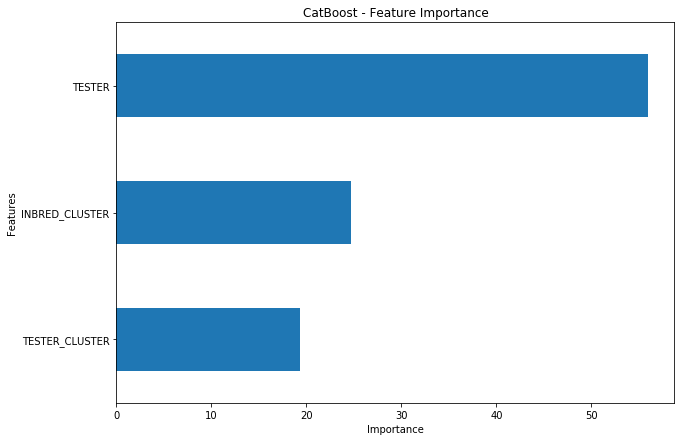

In [53]:
#Catboost feature importance
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X_train.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

# LightGBM

In [54]:
import lightgbm as lgb

# LightGBM model 1

In [55]:
train = pd.read_csv('CC2020_train_final.csv')
test = pd.read_csv('CC2020_test_final.csv')

In [70]:
#Create new training and test dataset
df_train = train[train['YEAR']<18]
df_test = train[train['YEAR']==18]

In [71]:
#drop the YEAR, LOCATION column in new train and test data
df_train = df_train.drop(['YEAR','LOCATION'], axis=1)
df_test = df_test.drop(['YEAR','LOCATION'], axis=1)

In [72]:
categorical = ['INBRED','INBRED_CLUSTER','TESTER','TESTER_CLUSTER']
label_encoder = preprocessing.LabelEncoder()
for col in categorical:
    df_train[col] = label_encoder.fit_transform(df_train[col].astype(str))
    df_test[col] = label_encoder.fit_transform(df_test[col].astype(str))


In [73]:
#split training data set
X_train = df_train.drop(['YIELD'], axis=1)
y_train = df_train.YIELD

#split test dataset
X_test = df_test.drop(['YIELD'], axis=1)
y_test = df_test.YIELD


In [87]:
X = df_train.loc[:, df_train.columns != 'YIELD']
feature_names = X.columns.tolist()

In [88]:
# LightGBM dataset formatting 
lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=feature_names,
                categorical_feature = categorical)
lgvalid = lgb.Dataset(X_test, y_test,
                feature_name=feature_names,
                categorical_feature = categorical)

In [89]:
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 200,
    'max_depth': 15,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.6,
    'verbosity' : -1
}

lgb_clf = lgb.train(
    params,
    lgtrain,
    20000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train', 'valid'],
    early_stopping_rounds=500,
    verbose_eval=500
)



Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 0.0982	valid's rmse: 0.110903


In [91]:
from sklearn.metrics import mean_squared_error
print("RMSE of the validation set:", np.sqrt(mean_squared_error(y_test, lgb_clf.predict(X_test))))

RMSE of the validation set: 0.11090280982145495


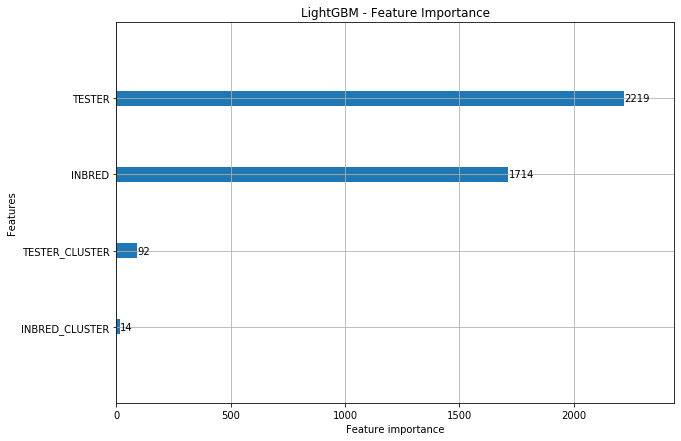

In [84]:
#feature importance
fig, ax = plt.subplots(figsize=(10, 7))
lgb.plot_importance(lgb_clf, max_num_features=30, ax=ax)
plt.title("LightGBM - Feature Importance");

In [94]:
params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.004,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
lgtrain = lgb.Dataset(X_train, label=y_train)
lgval = lgb.Dataset(X_test, label=y_test)
evals_result = {}
model = lgb.train(params, lgtrain, 5000, 
                  valid_sets=[lgtrain, lgval], 
                  early_stopping_rounds=100, 
                  verbose_eval=150, 
                  evals_result=evals_result)
    
pred_test_y = np.expm1(model.predict(X_test, num_iteration=model.best_iteration))
print(pred_test_y, model, evals_result)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 0.101405	valid_1's rmse: 0.110174
[1.72522925 1.72522925 1.72522925 ... 1.72501808 1.72501808 1.72501808] <lightgbm.basic.Booster object at 0x1a23ff55f8> {'training': OrderedDict([('rmse', [0.1014049543681324, 0.10139422303325485, 0.10138377436117414, 0.10137315996987267, 0.10136282564164875, 0.10135232695865172, 0.1013421053121452, 0.10133172085284486, 0.10132166214315685, 0.10131139041920376, 0.10130138934499755, 0.10129122877575979, 0.10128098803010256, 0.10127093783557087, 0.1012611507749733, 0.10125120903992284, 0.10124103900804265, 0.10123120434094575, 0.10122162621399676, 0.10121188427119167, 0.10120240382017713, 0.10119277863069479, 0.10118340035953322, 0.10117387821859025, 0.10116458879828864, 0.10115515572951189, 0.10114588444329635, 0.10113656516696357, 0.10112741024535296, 0.10111817851831581, 0.10110898258907154, 0.1010998610250504, 0.10109075049454203, 0.1

# Light GBM Model 2

In [95]:
train = pd.read_csv('CC2020_train_final.csv')
test = pd.read_csv('CC2020_test_final.csv')

In [96]:
#Create new training and test dataset
df_train = train[train['YEAR']<18]
df_test = train[train['YEAR']==18]

In [97]:
#drop the YEAR, LOCATION column in new train and test data
df_train = df_train.drop(['YEAR','LOCATION','INBRED_CLUSTER'], axis=1)
df_test = df_test.drop(['YEAR','LOCATION','INBRED_CLUSTER'], axis=1)

In [98]:
categorical = ['INBRED','TESTER','TESTER_CLUSTER']
label_encoder = preprocessing.LabelEncoder()
for col in categorical:
    df_train[col] = label_encoder.fit_transform(df_train[col].astype(str))
    df_test[col] = label_encoder.fit_transform(df_test[col].astype(str))


In [99]:
#split training data set
X_train = df_train.drop(['YIELD'], axis=1)
y_train = df_train.YIELD

#split test dataset
X_test = df_test.drop(['YIELD'], axis=1)
y_test = df_test.YIELD

In [100]:
X = df_train.loc[:, df_train.columns != 'YIELD']
feature_names = X.columns.tolist()

In [101]:
# LightGBM dataset formatting 
lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=feature_names,
                categorical_feature = categorical)
lgvalid = lgb.Dataset(X_test, y_test,
                feature_name=feature_names,
                categorical_feature = categorical)

In [102]:
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 200,
    'max_depth': 15,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.6,
    'verbosity' : -1
}

lgb_clf = lgb.train(
    params,
    lgtrain,
    20000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train', 'valid'],
    early_stopping_rounds=500,
    verbose_eval=500
)



/Users/edima/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds
[500]	train's rmse: 0.092277	valid's rmse: 0.116932
Early stopping, best iteration is:
[9]	train's rmse: 0.10062	valid's rmse: 0.110051


In [103]:
from sklearn.metrics import mean_squared_error
print("RMSE of the validation set:", np.sqrt(mean_squared_error(y_test, lgb_clf.predict(X_test))))

RMSE of the validation set: 0.11005057375508487


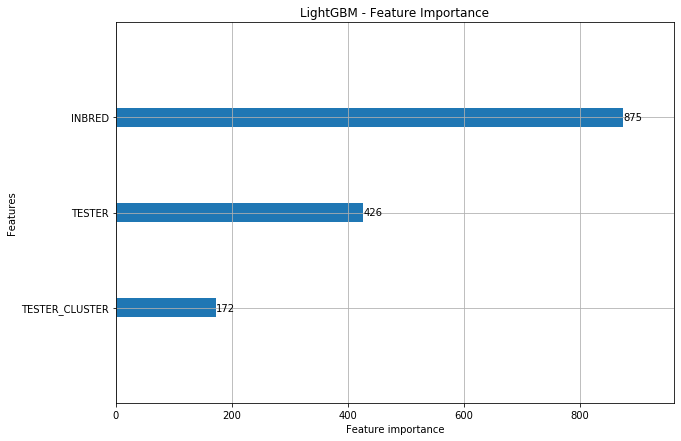

In [104]:
#feature importance
fig, ax = plt.subplots(figsize=(10, 7))
lgb.plot_importance(lgb_clf, max_num_features=30, ax=ax)
plt.title("LightGBM - Feature Importance");

In [105]:

params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.004,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
lgtrain = lgb.Dataset(X_train, label=y_train)
lgval = lgb.Dataset(X_test, label=y_test)
evals_result = {}
model = lgb.train(params, lgtrain, 5000, 
                  valid_sets=[lgtrain, lgval], 
                  early_stopping_rounds=100, 
                  verbose_eval=150, 
                  evals_result=evals_result)
    
pred_test_y = np.expm1(model.predict(X_test, num_iteration=model.best_iteration))
print(pred_test_y, model, evals_result)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[9]	training's rmse: 0.10132	valid_1's rmse: 0.110152
[1.72707609 1.72707609 1.72707609 ... 1.7242518  1.72357417 1.7242518 ] <lightgbm.basic.Booster object at 0x1a23ffa240> {'training': OrderedDict([('rmse', [0.10140409269203003, 0.10139406069091601, 0.10138358705213088, 0.10137275346523682, 0.10136240901021305, 0.10135133085228733, 0.10134072390202888, 0.10133089309019296, 0.10132039421070896, 0.10131030986617835, 0.10130064513111194, 0.10129032456470746, 0.10128040204395104, 0.1012705567916883, 0.10126078889686932, 0.1012506828732929, 0.10124065653948931, 0.10123065153888887, 0.10122074838159985, 0.10121125760691652, 0.10120204397319912, 0.10119207908438653, 0.1011829814117948, 0.10117395504036919, 0.1011649991989454, 0.1011555360799161, 0.10114634000912287, 0.10113699362286645, 0.10112790703511233, 0.10111916453634093, 0.10111039178254207, 0.10110178510369938, 0.10109260918927095, 0.101

# Xgboost Model 1

In [11]:
import xgboost as xgb

In [12]:
train = pd.read_csv('CC2020_train_final.csv')
test = pd.read_csv('CC2020_test_final.csv')

In [13]:
#Create new training and test dataset
df_train = train[train['YEAR']<18]
df_test = train[train['YEAR']==18]

In [14]:
#drop the YEAR, LOCATION column in new train and test data
df_train = df_train.drop(['YEAR','LOCATION'], axis=1)
df_test = df_test.drop(['YEAR','LOCATION'], axis=1)

In [1]:
target_encode_columns = ['INBRED','TESTER','TESTER_CLUSTER','INBRED_CLUSTER']

target_encode_columns = ['region', 'strategy', 'method', 'mode', 'type', 'status']
target = ['pay_cont_dif']
target_encode_df = score_df[target_encode_columns + target].reset_index().drop(columns = 'index', axis = 1)
target_name = target[0]
target_df = pd.DataFrame()
for embed_col in target_encode_columns:
    val_map = target_encode_df.groupby(embed_col)[target].mean().to_dict()[target_name]
    target_df[embed_col] = target_encode_df[embed_col].map(val_map).values
    
score_target_drop = score_df.drop(target_encode_columns, axis = 1).reset_index().drop(columns = 'index', axis = 1)
score_target = pd.concat([score_target_drop, target_df], axis = 1)

NameError: name 'score_df' is not defined

In [15]:
#split training data set
X_train = df_train.drop(['YIELD'], axis=1)
y_train = df_train.YIELD

#split test dataset
X_test = df_test.drop(['YIELD'], axis=1)
y_test = df_test.YIELD

In [16]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

In [ ]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
#cv_results contains train and test RMSE metrics for each boosting round.

In [ ]:
#feature importance
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

In [ ]:
#

# Random forest

# Ensemble method

# Deep learning

# Recommendation system

In [ ]:

#lightfm, recsys, turicreate, scipy, suprise, seaborn
#https://www.datacamp.com/community/tutorials/recommender-systems-python
#    https://realpython.com/build-recommendation-engine-collaborative-filtering/
#        https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/